<a href="https://colab.research.google.com/github/Kuliah-Machine-Learning/2021-Batik-Kel-4/blob/main/Klasifikasi_Batik_Kelompok_4__VGG_19Net(v2_Modified).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi 4 Batik**

# Mengambil *Dataset* dari *Github*

In [1]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Kuliah-Machine-Learning/2021-Batik-Kel-4.git/trunk/datasetv2 > /dev/null

## Persiapan

Program ini dibuat untuk membedakan 4 jenis batik yaitu :

1.   hewan
2.   kawung
3.   parang
4.   tumpal

Pada program ini menggunakan metode *Convolutional Neural Network* (CNN) untuk melakukan klasifikasinya.

## Memasukan Fungsi *Library*

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

## Mengimpor Dataset

In [3]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls datasetv2
!ls datasetv2/train
!ls datasetv2/train/hewan
!ls datasetv2/train/kawung
!ls datasetv2/train/parang
!ls datasetv2/train/tumpal

test  train
hewan  kawung  parang  tumpal
'H (10).jpg'  'H (21).jpg'  'H (32).jpg'  'H (43).jpg'	'H (54).jpg'
'H (11).jpg'  'H (22).jpg'  'H (33).jpg'  'H (44).jpg'	'H (55).jpg'
'H (12).jpg'  'H (23).jpg'  'H (34).jpg'  'H (45).jpg'	'H (56).jpg'
'H (13).jpg'  'H (24).jpg'  'H (35).jpg'  'H (46).jpg'	'H (5).jpg'
'H (14).jpg'  'H (25).jpg'  'H (36).jpg'  'H (47).jpg'	'H (6).jpg'
'H (15).jpg'  'H (26).jpg'  'H (37).jpg'  'H (48).jpg'	'H (7).jpg'
'H (16).jpg'  'H (27).jpg'  'H (38).jpg'  'H (49).jpg'	'H (8).jpg'
'H (17).jpg'  'H (28).jpg'  'H (39).jpg'  'H (4).jpg'	'H (9).jpg'
'H (18).jpg'  'H (29).jpg'  'H (3).jpg'   'H (50).jpg'
'H (19).jpg'  'H (2).jpg'   'H (40).jpg'  'H (51).jpg'
'H (1).jpg'   'H (30).jpg'  'H (41).jpg'  'H (52).jpg'
'H (20).jpg'  'H (31).jpg'  'H (42).jpg'  'H (53).jpg'
'k (100).jpg'  'k (28).jpg'  'k (46).jpg'  'k (64).jpg'  'k (82).jpg'
'k (10).jpg'   'k (29).jpg'  'k (47).jpg'  'k (65).jpg'  'k (83).jpg'
'k (11).jpg'   'k (2).jpg'   'k (48).jpg'  'k (66).jpg'  'k 

In [4]:
#Perintah untuk memvisualisasikan satu gambar dari data train
!ls datasetv2
!ls datasetv2/train
!ls datasetv2/train/hewan
!ls datasetv2/train/kawung
!ls datasetv2/train/parang
!ls datasetv2/train/tumpal

test  train
hewan  kawung  parang  tumpal
'H (10).jpg'  'H (21).jpg'  'H (32).jpg'  'H (43).jpg'	'H (54).jpg'
'H (11).jpg'  'H (22).jpg'  'H (33).jpg'  'H (44).jpg'	'H (55).jpg'
'H (12).jpg'  'H (23).jpg'  'H (34).jpg'  'H (45).jpg'	'H (56).jpg'
'H (13).jpg'  'H (24).jpg'  'H (35).jpg'  'H (46).jpg'	'H (5).jpg'
'H (14).jpg'  'H (25).jpg'  'H (36).jpg'  'H (47).jpg'	'H (6).jpg'
'H (15).jpg'  'H (26).jpg'  'H (37).jpg'  'H (48).jpg'	'H (7).jpg'
'H (16).jpg'  'H (27).jpg'  'H (38).jpg'  'H (49).jpg'	'H (8).jpg'
'H (17).jpg'  'H (28).jpg'  'H (39).jpg'  'H (4).jpg'	'H (9).jpg'
'H (18).jpg'  'H (29).jpg'  'H (3).jpg'   'H (50).jpg'
'H (19).jpg'  'H (2).jpg'   'H (40).jpg'  'H (51).jpg'
'H (1).jpg'   'H (30).jpg'  'H (41).jpg'  'H (52).jpg'
'H (20).jpg'  'H (31).jpg'  'H (42).jpg'  'H (53).jpg'
'k (100).jpg'  'k (28).jpg'  'k (46).jpg'  'k (64).jpg'  'k (82).jpg'
'k (10).jpg'   'k (29).jpg'  'k (47).jpg'  'k (65).jpg'  'k (83).jpg'
'k (11).jpg'   'k (2).jpg'   'k (48).jpg'  'k (66).jpg'  'k 

In [5]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('datasetv2/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['hewan', 'kawung', 'parang', 'tumpal']

for i,label in enumerate(labels):
    folder = os.path.join("datasetv2/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 256 images belonging to 4 classes.
Found 63 images belonging to 4 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 4)
Bentuk array dari dataset validation (validasi) adalah: (63, 224, 224, 3) (63, 4)
Bentuk array dari dataset test (pengujian) adalah: (90, 224, 224, 3) (90,)


## Menyimpan Label

In [6]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'hewan': 0, 'kawung': 1, 'parang': 2, 'tumpal': 3}


In [7]:
!cat labels.txt

hewan
kawung
parang
tumpal

# Membuat Model dari Jaringan CNN yang Sudah dipelajari Sebelumnya (*pre-trained convnets*)

In [8]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model VGG16
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

80150528/80134624 [==============================] - 0s 0us/step


## *Feature Extraction*

Menggunakan model *pre-trained* untuk ekstraksi fitur (*feature extraction*) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat contoh model *pre-trained* dan menambahkan classifier yang sepenuhnya terhubung di atas. Model *pre-trained* adalah "beku" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusional mengekstraksi semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih classifier yang menentukan kelas gambar mengingat set fitur yang diekstraksi.

In [9]:
base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Mengelompokkan Klasifikasi Tiga Jenis Beras dengan *Deep learning* (*Convolutional Neural Network*)

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [10]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

## Mempersiapkan Data Masukkan Pengujian

In [11]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

## Pembuatan Model (Menambah Model)

In [12]:
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.Conv2D(24, 3, activation='relu'),   
    tf.keras.layers.Conv2D(26, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),

    tf.keras.layers.GlobalAveragePooling2D(),
   
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 24)          110616    
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 26)          5642      
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 32)          7520      
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                        

## Pelatihan

In [13]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
#ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(train_generator, 
                    epochs=100, 
                    validation_data=val_generator)
#history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
2/2 [==============================] - 107s 63s/step - loss: 1.3689 - acc: 0.3555 - val_loss: 1.1684 - val_acc: 0.5079
Epoch 2/100
2/2 [==============================] - 101s 61s/step - loss: 1.1385 - acc: 0.4766 - val_loss: 0.9823 - val_acc: 0.7143
Epoch 3/100
2/2 [==============================] - 102s 61s/step - loss: 0.8512 - acc: 0.7969 - val_loss: 0.7455 - val_acc: 0.8413
Epoch 4/100
2/2 [==============================] - 101s 60s/step - loss: 0.5509 - acc: 0.9180 - val_loss: 0.4486 - val_acc: 0.9683
Epoch 5/100
2/2 [==============================] - 101s 60s/step - loss: 0.3084 - acc: 0.9414 - val_loss: 0.3052 - val_acc: 0.9683
Epoch 6/100
2/2 [==============================] - 101s 60s/step - loss: 0.1735 - acc: 0.9648 - val_loss: 0.2651 - val_acc: 0.8889
Epoch 7/100
2/2 [==============================] - 101s 61s/step - loss: 0.0883 - acc: 0.9805 - val_loss: 0.1323 - val_acc: 0.9683
Epoch 8/100
2/2 [==============================] - 100s 60s/step - loss: 0.0411 - a

## Menggambarkan Hasil Pelatihan

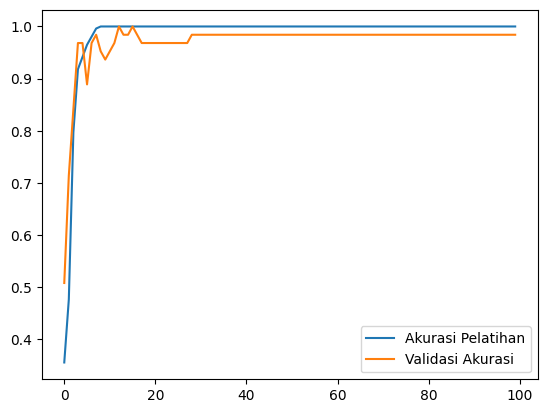

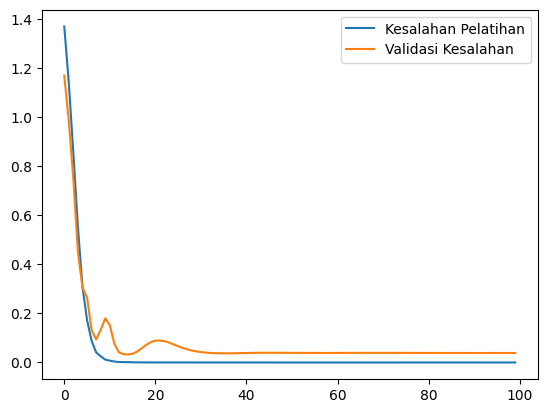

In [14]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [15]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 8


## Menggunakan Model

In [16]:
print(train_generator)

In [17]:
#Prediksi Label Validasi dengan Pelatihan
n = 44
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 1. 0. 0.]
Prediksinya adalah [1.5505206e-08 1.0000000e+00 2.7941488e-10 4.7525425e-11]


Hasil tersebut merupakan hasil prediksi dari training dari 3 jenis data pelatihan yaitu jenis beras Cilamaya, IR 64, dan Ketan. Menggunakan inputan gambar dengan piksel 224 x 224, 1 filter dengan fungsi aktivasi relu, dan 1 layer output dengan fungsi aktivasi softmax

## Evaluasi

In [18]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
2/2 [==============================] - 80s 40s/step - loss: 2.4280e-05 - acc: 1.0000
[2.428013613098301e-05, 1.0]
1/1 [==============================] - 20s 20s/step - loss: 0.0386 - acc: 0.9841
[0.0386362299323082, 0.9841269850730896]
3/3 [==============================] - 29s 9s/step - loss: 0.1104 - acc: 0.9778
[0.1104004979133606, 0.9777777791023254]


In [19]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1]


## Prediksi Gambar Individual

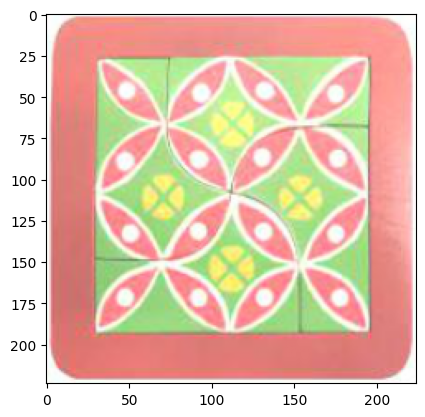

Label yang benar adalah: 1 : kawung
Nilai yang diprediksi adalah: [1.9677374e-05 9.9997461e-01 2.2575467e-08 5.7066363e-06]
Label yang diprediksi adalah: 1 : kawung
Prediksi benar


In [20]:
n = 12 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

## *Confusion Matrix*

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.03 0.03 0.94]]


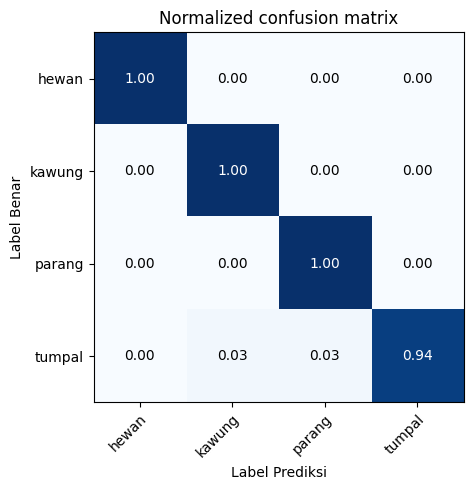

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

# Menyimpan dan Konversi ke ".tflite"

Menyimpan model menggunakan tf.saved_model.save dan kemudian mengonversi model tersimpan ke format yang kompatibel tf lite.

In [22]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_4_Jenis_Batik.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets
